<a href="https://colab.research.google.com/github/Foxy1987/neuroGLM/blob/master/HowTo_fit_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning: GLMs
__Content creator:__ David Fox


Hello. I developed a library of python modules which supports fitting and analysis of trial-based time series data in sensory neuroscience using a generalized linear model (GLM). The time series could represent neural spike responses or behavioral responses to arbitrary stimulus presentations. 

For example, we record spike responses from a single neuron or the behavioral response of an animal to multiple presentations of a stimulus, and would like to know what aspects of the stimulus are encoded in the neural response or behavior. This code package allows us to discover such dependencies.

Response variables, here neural recordings or behavior, are are accompanied by various other controlled manipulations or measurements, here an olfactory stimulus. It is hard to find a representation of the stimulus (called a regressor) in the response for regression-style analysis because they don't have an instantaneous effect on the response (dependent) variable. This package allows you to expand and transform your experimental variables (stimulus) to a feature space as a design matrix that is amenable to regression. This allows you to find out the relationship between the response variable and each regressor as a function of time.

This tutorial will explain how to import trial-based experimental data, and build appropriate features spaces to do regression analysis. The ultimate output of the regression is a set of weights on the coefficients that define a stimulus filter (and a post-spike filter)

The filter weights of the linear regression model can be estimated in one of two ways:
1.   Least squares (ridge-regression with cross-validation)
2.   maximum-likelihood estimation under a Poissson GLM model with an exponential nonlinearity

To learn more about GLMs visit: https://mfr.ca-1.osf.io/render?url=https://osf.io/8sqhc/?direct%26mode=render%26action=download%26mode=render





# Import package and libraries

In [2]:
#@title Clone the github repository 
!git clone https://github.com/Foxy1987/neuroGLM
%cd neuroGLM


Cloning into 'neuroGLM'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 137 (delta 58), reused 100 (delta 38), pack-reused 0
Receiving objects: 100% (137/137), 232.78 KiB | 892.00 KiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/neuroGLM


In [3]:
#@title add package to google colab
import sys, os
sys.path.append(os.getcwd())

In [4]:
#@title import modules
from glmtools.make_xdsgn import DesignMatrix, Experiment, DesignSpec
import utils.read as io
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from glmtools.fit import neg_log_lik

# Upload files from your local drive to google colab: 

These files should be the following:
1.   stimulus file: this is a regular txt file containing a single column representing the stimulus waveform
2.   spike times file: a .mat file containing a cell array. Each cell is a trial and should contain an array of the times a neuron spiked in response to that stimulus.



In [ ]:
from google.colab import files
uploaded = files.upload()

In [5]:
stim, sptimes = io.load_spk_times('datasets/stim.txt', 'datasets/spTimesPNControl/pn1SpTimes_reverseChirp.mat', 5, 30)

In [6]:
!ls datasets/

spTimesPNControl  stim.txt


# Bin the spike times
Now we will bin the spike times using the same time bin size used for the stimulus. We will use the time bin centers to bin the spike train.


In [8]:
trials = len(sptimes)
duration = 25
nt = len(stim)
stim = (stim / np.max(stim))*0.01
dt = 0.001                                # 1 ms time bins = 1 KHz sample frequency
t = (np.arange(nt))*dt
sp_count_fun = lambda x: np.histogram(x, np.arange(0.5, len(stim)+1) * dt - dt)[0] 
sps = list(map(sp_count_fun, sptimes))    # apply the binning function sp_count_fun to each trial
stim_ = np.tile(stim, (trials, 1))        # we need a stim for every trial


# Create an experiment object 
Now we will make an experiment object to hold response variable and to register the types of regressors in the experiment

In [ ]:
# make an Experiment object
expt = Experiment(dt, duration, stim=stim_, sptimes=sps)

# register continuous external regressor
expt.registerContinuous('stim')

# register internal sptrain regressor
expt.register_spike_train('sptrain')

# lets visualize our stimulus and response

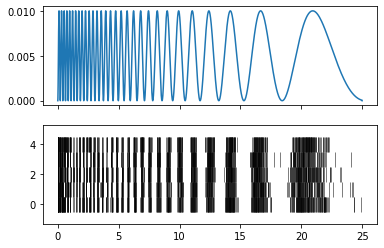

In [ ]:
sps_ = np.empty((len(stim), trials))
actual = list(map(sp_count_fun, sptimes))
actual_ = list(map(lambda x: x * (np.arange(len(stim)) + 1) * dt, actual))
for i in range(5):
	sps_[:, i] = actual_[i].T

# Share a X axis with each column of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col')
ax1.plot(t, stim)
ax2.eventplot(sps_.T, colors='k', linewidth=0.5)



# Create an Experiment object
Now we will make an experiment object to hold response variable and to register the types of regressors in the experiment

In [ ]:
# make an Experiment object
expt = Experiment(dt, duration, stim=stim_, sptimes=sps)

# register continuous external regressor
expt.registerContinuous('stim')

# register internal sptrain regressor
expt.register_spike_train('sptrain')

# Create a design specification object
This object holds all the information about how to construct the design matrix for each regressor. The function compile_design_matrix_from_trial_indices() stacks design matrices for a given regressor and for each trial on top of one another. 

In [ ]:
trial_inds = list(range(len(sptimes)))
dspec = DesignSpec(expt, trial_inds)

# add stim and spike history regressors
dspec.addRegressorContinuous()
dspec.addRegressorSpTrain()

# Build the design matrix and view the contents
Now we use the information about each regressor included in the experiment and the number of trials to construct a design matrix

In [ ]:
dm, X, y = dspec.compileDesignMatrixFromTrialIndices()

forming design matrix from trial indices
forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
convolving padded stimulus with raised cosine basis functions
forming design matrix from trial indices
forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
convolving padded stimulus with raised cosine basis functions
forming design matrix from trial indices
forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
convolving padded stimulus with raised cosine basis functions
forming design matrix from trial indices
forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
convolving padded stimulus with raised cosine basis functions
forming design matrix from trial indices
forming design matrix from trial indices
convolving padded stimulus with raised cosine basis functions
convolving padded stimulus with 

# Nonlinear optimization with `scipy.optimize
We will use scipy.optimize.minimize to compute maximum likelihood estimates for the filter weights in the Poissson GLM model with an exponential nonlinearity.

We defined an *objective function* called neg_log_lik that takes as input a design matrix, a spike count vector, and a vector of parameters and returns a negative log likelihood.

What should the objective function look like? We want it to return the negative log likelihood: $-\log P(y \mid X, \theta).$

In the Poisson GLM,

$$
\log P(\mathbf{y} \mid X, \theta) = \sum_t \log P(y_t \mid \mathbf{x_t},\theta),
$$

where

$$ P(y_t \mid \mathbf{x_t}, \theta) = \frac{\lambda_t^{y_t}\exp(-\lambda_t)}{y_t!} \text{, with rate } \lambda_t = \exp(\mathbf{x_t}^{\top} \theta).$$

Now, taking the log likelihood for all the data we obtain:
$\log P(\mathbf{y} \mid X, \theta) = \sum_t( y_t \log(\lambda_t) - \lambda_t - \log(y_t !)).$

Because we are going to minimize the negative log likelihood with respct to the parameters $\theta$, we can ignore the last term that does not depend on $\theta$. For faster implementation, let us rewrite this in matrix notation:

$$\mathbf{y}^T \log(\mathbf{\lambda}) - \mathbf{1}^T \mathbf{\lambda} \text{, with  rate } \mathbf{\lambda} = \exp(X^{\top} \theta)$$

Finally, don't forget to add the minus sign for your function to return the negative log likelihood.

Use a random vector of weights to start (mean 0, sd .2) and call the minimize function

In [ ]:
prs = [0.0, -16.9989, 4.5455, 1.1125, 0.8270, -1.3354]
ih_pars = np.random.normal(0, .2,  8)
prs = np.concatenate((prs, ih_pars), axis=0)
res = minimize(neg_log_lik, prs, args=(5, X, y, 1),
										options={'maxiter': 1000, 'disp': True})

theta_ml = res['x']

         Current function value: -6082.588968
         Iterations: 46
         Function evaluations: 1041
         Gradient evaluations: 65
[  0.         -16.9989       4.5455       1.1125       0.827
  -1.3354       0.05087387   0.19106999  -0.04786452   0.07591123
  -0.0727497   -0.27738155   0.06097944   0.06738429]


# Combine the weights across the basis functions for each filter
Now we need to combine the weights across each of the basis functions to get the stimulus filter and post-spike filter. These filters are saved in a dictionary for easy access.

In [ ]:
# combine weights across each basis vector
d = dm.get_regressor_from_output(theta_ml)

dc = theta_ml[0]
k = d['stim'][1]
kt = d['stim'][0] * dt
h = d['sptrain'][1]
ht = d['sptrain'][0] * dt

print("DC bias term is {} spikes/s".format(dc))

DC bias term is 1.4810733822918412 spikes/s


# Plot the stimulus filter and the postspike filter

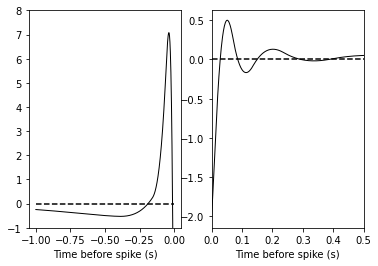

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(kt, k, '-k', linewidth=1)
ax2.plot(ht, h, '-k', linewidth=1)
ax1.plot([-1, 0], [0, 0], '--k')
ax2.plot([0, .5], [0, 0], '--k')
ax2.set_xlim(0, 0.5)
ax1.set_ylim(-1, 8)
ax1.set_xlabel('Time before spike (s)')
ax2.set_xlabel('Time before spike (s)')
plt.show()